# Research on apartment sales ads

You will have the data from a real estate agency. It is an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. You’ll need to learn how to determine the market value of real estate properties. Your task is to define the parameters. This will make it possible to build an automated system that is capable of detecting anomalies and fraudulent activity.

There are two different types of data available for every apartment for sale. The first type is a user’s input. The second type is received automatically based upon the map data. For example, the distance from the downtown area, airport, the nearest park or body of water. 

# General Functions

In [1]:
def get_percent_of_na(df,num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index,s.values):
        
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent,num,num_of_nulls))
        
    if count !=0:
        print('There are {} columns with NA!'.format(count))
    else:
        print()
        print('There are no columns with NA!')
    pass

        
        
def get_value_counts(df):
    df = df.copy()
    for col in df.columns:
        print('Values for the column: {}'.format(col), df[col].value_counts(),sep='\n')
    pass


def fill_NA(df,groupby,columns,func):
    if not isinstance(columns,list):
        raise ValueError('Need to be a list')
    df = df.copy()
    for col in columns:
        df[col] = df.groupby(groupby)[col].apply(lambda x: x.fillna(func(x)))
        df[col] = df[col].fillna(0).round()
    return df


def find_pairs_with_correlation_above(df, columns, threshold):
        '''
            :param df: dataframe rows are deals, columns are property characteristics 
            :param columns: subset of the numerical columns in the df
            :return: list of tuples: [(attr_name, attr_name, correlation)] of pairs of columns with absolute correlation 
                above threshold
        '''
        correlation_matrix = df.corr().round(5)
        c = correlation_matrix.stack().drop_duplicates().reset_index().values
        tp = [tuple(x) for x in c if abs(x[2]) >= threshold and abs(x[2])!=1]
        return tp
    
    
def get_numerical_columns(df):
        '''
            The function returns a list of names of all numerical columns in self.df
            :return: a list with columns names that correspond to columns with numerical data;
        '''
        return [x for x in df.columns if np.issubdtype(df[x],np.number)]

### Step 1. Open the data file and study the general information. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,St Petersburg,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,Shushary village,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,St Petersburg,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,St Petersburg,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,St Petersburg,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### General Information Gathering:

In [4]:
df.shape

(23699, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [6]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [7]:
df.describe(include='object')

,first_day_exposition,is_apartment,locality_name
count,23699,2775,23650
unique,1491,2,329
top,2018-02-01T00:00:00,False,St Petersburg
freq,368,2725,15721


In [8]:
get_percent_of_na(df,2)

Column ceiling_height has 38.80% percent of Nulls, and 9195 of nulls
Column floors_total has 0.36% percent of Nulls, and 86 of nulls
Column living_area has 8.03% percent of Nulls, and 1903 of nulls
Column is_apartment has 88.29% percent of Nulls, and 20924 of nulls
Column kitchen_area has 9.61% percent of Nulls, and 2278 of nulls
Column balcony has 48.61% percent of Nulls, and 11519 of nulls
Column locality_name has 0.21% percent of Nulls, and 49 of nulls
Column airports_nearest has 23.38% percent of Nulls, and 5542 of nulls
Column cityCenters_nearest has 23.29% percent of Nulls, and 5519 of nulls
Column parks_around3000 has 23.28% percent of Nulls, and 5518 of nulls
Column parks_nearest has 65.91% percent of Nulls, and 15620 of nulls
Column ponds_around3000 has 23.28% percent of Nulls, and 5518 of nulls
Column ponds_nearest has 61.56% percent of Nulls, and 14589 of nulls
Column days_exposition has 13.42% percent of Nulls, and 3181 of nulls
There are 14 columns with NA!


### Conclusion

After Investigating the data I can see that I have 14 columns with nulls.
Each column has alot of nulls, the range of nulls vary from 10% to 88% (except from the columns floors total and locality).

Therefore, I'll have to handle these columns:
- [X] ceiling_height
- [X] floors_total
- [X] living_area
- [X] is_apartment
- [X] kitchen_area
- [X] balcony
- [X] locality_name
- [X] airports_nearest
- [X] cityCenters_nearest
- [X] parks_around3000
- [X] ponds_around3000
- [X] ponds_nearest
- [X] parks_nearest
- [X] days_exposition

### Step 2. Data preprocessing

Firstly, I will handle locality_name, balcony and is_apartment.

Since locality name has a dominator with St. Petersburg, I will fill NA with this. For balcony I allow myself to replace NA with 0, since if it is not filled probably no balcony for the apartment. 
About is_apartment, I am gonna fill False, since 98% from the values are False. After that I can drop that column since this column does not add any value when it is only False (99.7% False).

In [9]:
df['is_apartment'].value_counts() / df['is_apartment'].value_counts().sum()

False    0.981982
True     0.018018
Name: is_apartment, dtype: float64

In [10]:
df['is_apartment'].fillna(0,inplace=True)

In [11]:
df['is_apartment'].value_counts() / df['is_apartment'].value_counts().sum()
df.drop(columns=['is_apartment'],inplace=True)

In [12]:
df['locality_name'].fillna(df['locality_name'].value_counts().idxmax(),inplace=True)

In [13]:
df['balcony'].fillna(0, inplace=True)

Secondly, I am going to check the floor. Since floor is the apartment floor, it should be <= to floors_total. I am gonna to verify that this is the case.

Since no results, we are ok.

In [14]:
df[df['floor'] > df['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Lastly, I will work on the other columns.

Since the mean and median for airport, city, park, etc are kinda close, I take the liberty to group by locality name and fill out these nulls with the avg of the group. However, I saw that we have some localities without a single values, therefore after filling the mean I'll replace the NA with 0 to avoid changing the data too much.

P.S:

The numbers will be rounded to avoid having 1 and a half airport or city center

In [15]:
columns_to_fill = ['airports_nearest','cityCenters_nearest','parks_around3000','parks_nearest','ponds_around3000','ponds_nearest']
df = fill_NA(df,'locality_name',columns_to_fill,np.mean)

In [16]:
get_percent_of_na(df,2)

Column ceiling_height has 38.80% percent of Nulls, and 9195 of nulls
Column floors_total has 0.36% percent of Nulls, and 86 of nulls
Column living_area has 8.03% percent of Nulls, and 1903 of nulls
Column kitchen_area has 9.61% percent of Nulls, and 2278 of nulls
Column days_exposition has 13.42% percent of Nulls, and 3181 of nulls
There are 5 columns with NA!


For the rest of the columns, I will try to investigate the correlation between columns, to better understand how to fill the missing values.

In [17]:
pairs = find_pairs_with_correlation_above(df,get_numerical_columns(df),0.5)
pairs

[('last_price', 'total_area', 0.65368),
 ('last_price', 'living_area', 0.56649),
 ('last_price', 'kitchen_area', 0.51987),
 ('total_area', 'rooms', 0.75834),
 ('total_area', 'living_area', 0.93954),
 ('total_area', 'kitchen_area', 0.60912),
 ('rooms', 'living_area', 0.84598),
 ('floors_total', 'floor', 0.67806),
 ('airports_nearest', 'cityCenters_nearest', 0.60394),
 ('parks_nearest', 'ponds_nearest', 0.5315)]

I can see that I have 10 couples with correlation above 0.5.

Since total_area and rooms has no nulls, I'll groupby these columns and fill living area and kitchen area by the median of every group, check results then by avg.

Later, I can choose the best method that gives the higher correlation.

In [18]:
df_test = df[['total_area','rooms','living_area','kitchen_area']]
df_test = fill_NA(df_test,['total_area','rooms'],['living_area','kitchen_area'],np.mean)
pairs_test_mean = find_pairs_with_correlation_above(df_test,get_numerical_columns(df_test),0.5)
pairs_test_mean

[('total_area', 'rooms', 0.75834),
 ('total_area', 'living_area', 0.86931),
 ('total_area', 'kitchen_area', 0.56812),
 ('rooms', 'living_area', 0.82186)]

In [19]:
df_test = df[['total_area','rooms','living_area','kitchen_area']]
df_test = fill_NA(df_test,['total_area','rooms'],['living_area','kitchen_area'],np.median)
pairs_test_mean = find_pairs_with_correlation_above(df_test,get_numerical_columns(df_test),0.5)
pairs_test_mean

[('total_area', 'rooms', 0.75834),
 ('total_area', 'living_area', 0.79166),
 ('total_area', 'kitchen_area', 0.51409),
 ('rooms', 'living_area', 0.74464)]

Filling up the NA with mean gave me better results. Although I did lose some of the correlation

In [20]:
df = fill_NA(df,['total_area','rooms'],['living_area','kitchen_area'],np.mean)

Let us see which columns are still having NA

In [21]:
get_percent_of_na(df,2)

Column ceiling_height has 38.80% percent of Nulls, and 9195 of nulls
Column floors_total has 0.36% percent of Nulls, and 86 of nulls
Column days_exposition has 13.42% percent of Nulls, and 3181 of nulls
There are 3 columns with NA!


For floors total I will fill it with median based on locality, probably for same areas the number of floors for buildings should be around each other.

For ceiling I am gonna fill with median.

Lastly, for days exposition will do a deeper investigation.

In [22]:
#filling NA with floors assuming it is the highest floor.
df['floors_total'].fillna(df['floor'],inplace=True)

In [23]:
df['ceiling_height'].fillna(df['ceiling_height'].median(),inplace=True)

In [24]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [25]:
df.groupby(['locality_name'])['days_exposition'].describe().head(20)

,count,mean,std,min,25%,50%,75%,max
locality_name,,,,,,,,
Agalatovo village,3.0,223.666667,347.192070,5.0,23.50,42.0,333.00,624.0
Aleksandrovskaya village,2.0,78.500000,47.376154,45.0,61.75,78.5,95.25,112.0
Annino village,13.0,265.384615,285.143104,7.0,60.00,172.0,375.00,859.0
Ascension settlement,2.0,138.500000,58.689863,97.0,117.75,138.5,159.25,180.0
Baryshevo village,2.0,252.500000,303.348809,38.0,145.25,252.5,359.75,467.0
Batovo village,7.0,132.714286,123.328443,27.0,61.50,86.0,151.50,390.0
Begunitsy village,16.0,167.625000,143.793776,20.0,45.00,142.5,192.50,525.0
Belogorka village,10.0,357.800000,319.448066,37.0,67.00,339.5,527.25,1021.0
Beloostrov village,1.0,45.000000,NaN,45.0,45.00,45.0,45.00,45.0


In [26]:
df.groupby(['locality_name','rooms'])['days_exposition'].describe().head(20)

count        mean         std    min    25%  \
locality_name            rooms                                                
Agalatovo village        1        1.0   42.000000         NaN   42.0   42.0   
                         2        1.0    5.000000         NaN    5.0    5.0   
                         3        1.0  624.000000         NaN  624.0  624.0   
Aleksandrovskaya village 2        1.0   45.000000         NaN   45.0   45.0   
                         4        1.0  112.000000         NaN  112.0  112.0   
Annino village           1        2.0   54.000000   12.727922   45.0   49.5   
                         2        9.0  363.333333  294.410003    7.0  172.0   
                         3        2.0   36.000000   33.941125   12.0   24.0   
Ascension settlement     2        1.0   97.000000         NaN   97.0   97.0   
                         3        1.0  180.000000         NaN  180.0  180.0   
Baryshevo village        2        1.0  467.000000         NaN  467.0  467.0   
                         3        1.0   38.000000         NaN   38.0   38.0   
Batovo village           1        1.0  139.000000         NaN  139.0  139.0   
                         2        3.0  109.333333   47.511402   78.0   82.0   
                         3        3.0  154.000000  204.580058   27.0   36.0   
Begunitsy village        1        2.0  231.000000  100.409163  160.0  195.5   
                         2        6.0  164.000000  144.514359   45.0   59.5   
                         3        8.0  154.500000  163.075793   20.0   45.0   
Belogorka village        1        3.0  367.666667  297.775643   44.0  236.5   
                         2        5.0  432.000000  388.581394   42.0  136.0   

                                  50%    75%     max  
locality_name            rooms                        
Agalatovo village        1       42.0   42.0    42.0  
                         2        5.0    5.0     5.0  
                         3      624.0  624.0   624.0  
Aleksandrovskaya village 2       45.0   45.0    45.0  
                         4      112.0  112.0   112.0  
Annino village           1       54.0   58.5    63.0  
                         2      210.0  559.0   859.0  
                         3       36.0   48.0    60.0  
Ascension settlement     2       97.0   97.0    97.0  
                         3      180.0  180.0   180.0  
Baryshevo village        2      467.0  467.0   467.0  
                         3       38.0   38.0    38.0  
Batovo village           1      139.0  139.0   139.0  
                         2       86.0  125.0   164.0  
                         3       45.0  217.5   390.0  
Begunitsy village        1      231.0  266.5   302.0  
                         2      133.0  188.5   431.0  
                         3      110.5  189.5   525.0  
Belogorka village        1      429.0  529.5   630.0  
                         2      401.0  560.0  1021.0

Since std is really high for this columns and also we have a huge gap between mean and median, I decide to groupby locality and rooms to fill median. 

After that will check how much it has changed before I filled NA.

In [27]:
df = fill_NA(df,['locality_name','rooms'],['days_exposition'],np.median)

In [28]:
df['days_exposition'].describe()

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

I can see that both of the median and mean dropped.

In [29]:
#last check to see if I finished with filling NA
get_percent_of_na(df,2)


There are no columns with NA!


In [30]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [31]:
#Will convert the next columns to integer, no point of float because these numbers shoould be rounded.
ls = ['floors_total','balcony','airports_nearest','cityCenters_nearest','parks_around3000','parks_nearest',
         'ponds_around3000','ponds_nearest','days_exposition']
df[ls] = df[ls].astype(int)
#this suppose to be a date column
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [32]:
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest                 int32
cityCenters_nearest              int32
parks_around3000                 int32
parks_nearest                    int32
ponds_around3000                 int32
ponds_nearest                    int32
days_exposition                  int32
dtype: object

### Conclusion

We had a lot of NA in our data. Filled some based on correlation, some based on intuition and some randomly.

All the types for the columns are correct.

### Step 3. Make calculations and add them to the table

In [33]:
def get_floor(x):
    """
    Function to categorize the floor. First, Last or Other.
    :param x: Floor number 
    :return: ndarray with results
    """
    return np.where(df['floor'] == df['floors_total'],'Last',np.where(df['floor'] == 1,'First','Other'))

def get_ratio(df,col1,col2):
    """
    Function to calculate ratio between two columns
    :param df: The desired dataframe
    :param col1: Column name to be numerator
    :param col2: denominator
    :return: Pandas Series of the divided two columns 
    """
    return df[col1] / df[col2]

In [34]:
#calculating the price per square meter
df['price_per_sq_meter'] = df['last_price'] / df['total_area']

#adding some other info to data based on day, month, year
df['year'] = df['first_day_exposition'].dt.year
df['day'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month

#adding floor status
df['floor_status'] = get_floor(df)

df['living_space_ratio'] = get_ratio(df,'living_area','total_area')
df['kitchen_ratio'] = get_ratio(df,'kitchen_area','total_area')

### Step 4. Conduct exploratory data analysis and follow the instructions below:

In [35]:
df.to_csv('after_proccess.csv')

In [36]:
df = pd.read_csv('after_proccess.csv')

#### Task
•Carefully investigate the following parameters: square area, price, number of rooms, and ceiling height. Plot a histogram for each parameter.

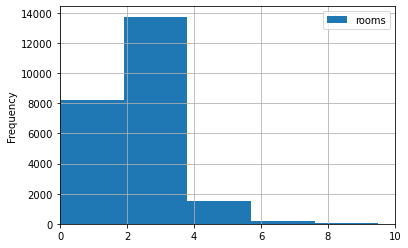

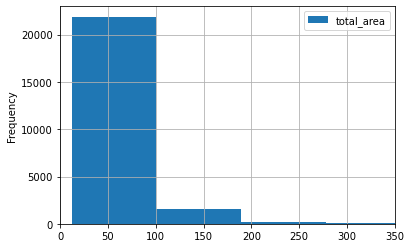

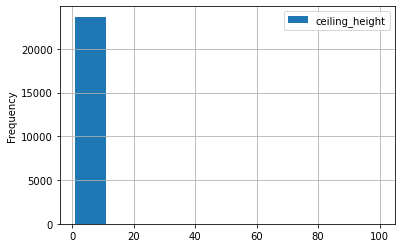

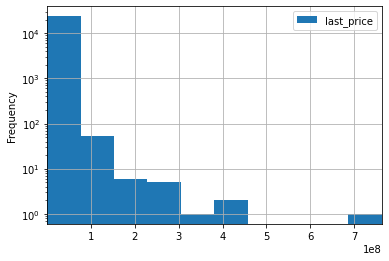

In [37]:
#investigating a few columns with hist plots to see the distribution:

df[['rooms']].plot(kind='hist',grid=True,bins = 10,xlim =(0,10))
df[['total_area']].plot(kind='hist',grid=True,bins = 10,xlim =(0,350))
df[['ceiling_height']].plot(kind='hist',grid=True)
df[['last_price']].plot(kind='hist',grid=True,bins = 10,xlim=(df['last_price'].min(),df['last_price'].max()),logy =True)

I can see from the graphs that last price has some really high numbers while the majority is <
\begin{equation*} \left( 3*10\right)^8\end{equation*} and is skewed to the left

For rooms I can see the majority is under 6, total area is under 200

#### Task
•Examine the time it's taken to sell the apartment and plot a histogram. Calculate the mean and median and explain the average time it usually takes to complete a sale. When can a sale be considered to have happened rather quickly or taken an extra long time?

In [38]:
df['days_exposition'].value_counts().sort_index().head(15)

0     3181
1        1
2        3
3      158
4      176
5      152
6      124
7      234
8      139
9      143
10     127
11     135
12     108
13     128
14     148
Name: days_exposition, dtype: int64

In [39]:
df['days_exposition'].value_counts().sort_index().tail(15)

1430    1
1434    1
1441    1
1452    1
1458    1
1477    1
1484    1
1485    1
1489    1
1497    1
1512    2
1513    1
1553    1
1572    1
1580    1
Name: days_exposition, dtype: int64

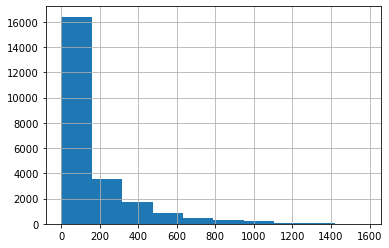

In [40]:
df['days_exposition'].hist()

In [41]:
df['days_exposition'].describe()

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

I can tell that a lot of ads were removed in the same day (having 0 in value) which I most admit to say it was extra quick. I assume that, if the ad was displayed for only a week it can be count as a quickly sale.

Highest value we have is 1580 which is something around 5 years. Personally, I think if an ad was displayed for more than a year I can say it was a long time and over two years, extra long time.

From the description I can tell that the mean time of having a sale is 156 days which is almost half a year and the median is 74 days which is less than 3 months.

<strong> To conclude: </strong>

Based on the number I allow myself to define a sale as quickly if it was displayed for maximum 30 days, long time if it was displayed for more than a year and extra long time for more than two years.

#### Task
•Remove rare and outlying values and describe the patterns you've discovered.

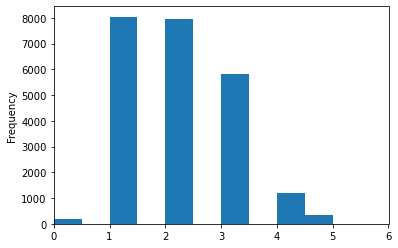

In [42]:
good_rooms = df[df['rooms'] <= df['rooms'].quantile(0.98)]['rooms']
good_rooms.plot(kind='hist', xlim=(0,6))

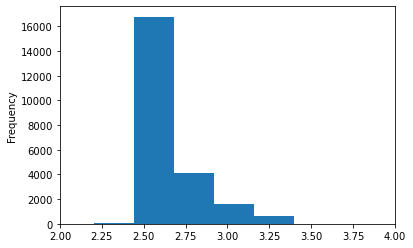

In [43]:
good_ceiling_height = df[df['ceiling_height'] <= df['ceiling_height'].quantile(0.98)]['ceiling_height']
good_ceiling_height.plot(kind='hist', xlim=(2,4))

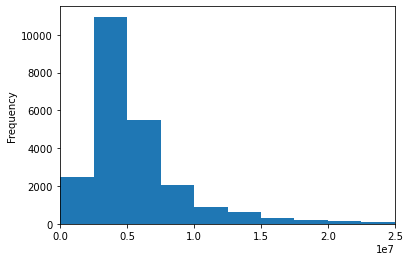

In [44]:
good_sale_price = df[df['last_price'] <= df['last_price'].quantile(0.98)]['last_price']
good_sale_price.plot(kind='hist',xlim=(0,df['last_price'].quantile(0.98)))

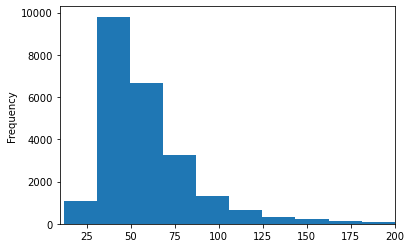

In [45]:
good_area = df[df['total_area'] <= 200]['total_area']
good_area.plot(kind='hist',xlim=(10,200))

After cleansing some of the columns, I can see that most of the apartments have 1 or 2 rooms, most of the sale price was 0.2 * 10** 8, a lot of apartments has less than 100 meters and ceiling height is roughly around 2.5-2.75.

#### Task
•Which factors have had the biggest influence on an apartment’s price? Examine whether the value depends on price per meter, number of rooms, floor (top or bottom), or the proximity to the downtown area. Also study the correlation to the publication date: day of the week, month, and year.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027AEDC18188>,
      dtype=object)

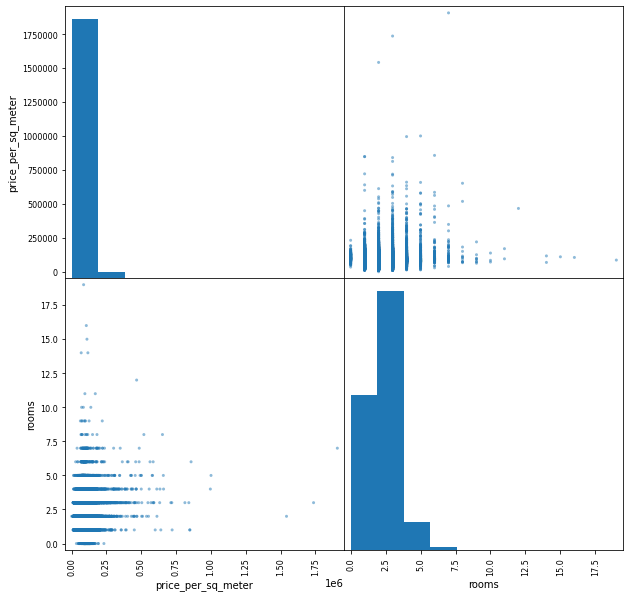

In [46]:
pd.plotting.scatter_matrix(df[['price_per_sq_meter','rooms','floor_status']], figsize=(10,10))

I can tell that the bigger the house is (more rooms) the higher the price is.

In [47]:
df[['year','month','day','price_per_sq_meter','rooms','floor_status']].corr()

,year,month,day,price_per_sq_meter,rooms
year,1.000000,-0.269642,-0.004799,0.008516,-0.055418
month,-0.269642,1.000000,0.011496,-0.001995,-0.004469
day,-0.004799,0.011496,1.000000,-0.007272,-0.004134
price_per_sq_meter,0.008516,-0.001995,-0.007272,1.000000,0.055420
rooms,-0.055418,-0.004469,-0.004134,0.055420,1.000000


all of the values are under 0.3 (or -0.3) which can indicates that we do not have a connection.

I will try to find some connection with grouping

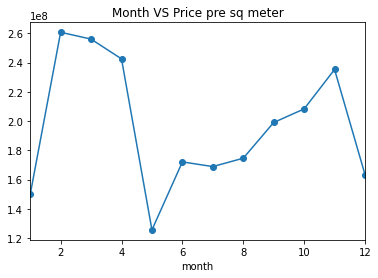

In [48]:
df.groupby(['month'])['price_per_sq_meter'].agg('sum').plot(style='o-',title='Month VS Price pre sq meter')

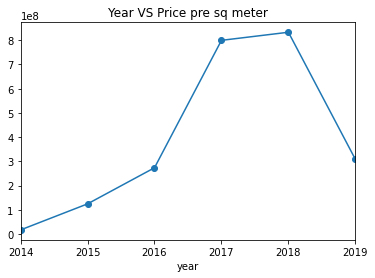

In [49]:
df.groupby(['year'])['price_per_sq_meter'].agg('sum').plot(style='o-',title='Year VS Price pre sq meter')

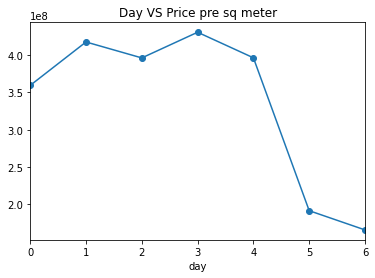

In [50]:
df.groupby(['day'])['price_per_sq_meter'].agg('sum').plot(style='o-',title='Day VS Price pre sq meter')

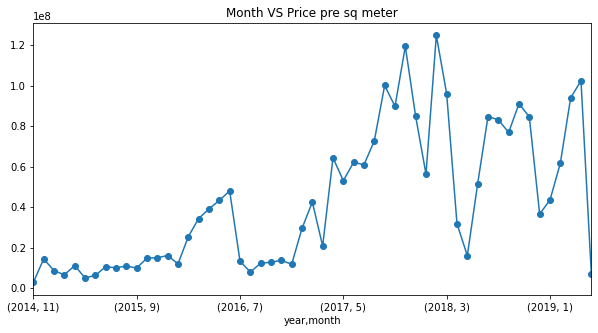

In [51]:
df.groupby(['year','month'])['price_per_sq_meter'].agg('sum').plot(style='o-',title='Month VS Price pre sq meter',figsize=(10,5))

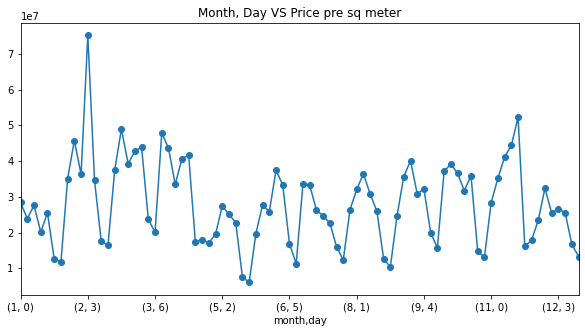

In [52]:
df.groupby(['month','day'])['price_per_sq_meter'].agg('sum').plot(style='o-',title='Month, Day VS Price pre sq meter',figsize=(10,5))

<strong> Conclusion </strong>

I can see that there is no seen correlation between price per sq meter in the correlation matrix. How ever, I tried to plot some scatters plot to see if there is a pattern in some years or months. I can see that there was a huge increase between 2016-2017 and a huge drop in 2018-2019, without investigating it deeper (find something on the news or such) I cant really conclude anything. However, for Month, Day we can see some patterns such as that every day 1 there is increase.

#### Task
•Select the 10 places with the largest number of ads then calculate the average price per square foot in these municipalities. Select the locations with the highest and lowest housing prices. You can find this data by name in the ’locality_name’ column.

In [53]:
largest_places = df['locality_name'].value_counts().nlargest(n=10).index.tolist()

In [54]:
df_largest = df[df['locality_name'].isin(largest_places)].reset_index(drop=True)

In [55]:
df_largest.groupby(['locality_name'])['price_per_sq_meter'].agg(['mean'])

,mean
locality_name,
Gatchina,68746.146763
Kolpino,75424.579098
Kudrovo village,92473.547576
Murino village,85681.762601
Pargolovo village,90175.913458
Shushary village,78677.364217
St Petersburg,114785.190679
Vyborg,58141.909153
ng role model.,103125.819291


#### Task
•Thoroughly look at apartment offers: Each apartment has information about the distance to the downtown area. Select apartments in Saint Petersburg (‘locality_name’). Your task is to pinpoint which area is considered to be downtown. Then create a column with the distance to the downtown area in km and round to the nearest whole number. Next, calculate the average price for each kilometer and plot a graph to display how prices are affected by the distance to the downtown area. Define the turning point where the graph significantly changes, which will indicate downtown.

In [56]:
new_df = df[df['locality_name']=='St Petersburg']

In [57]:
#Get the distance in KM
new_df['km_to_city_center'] = round(new_df['cityCenters_nearest'] / 1000)

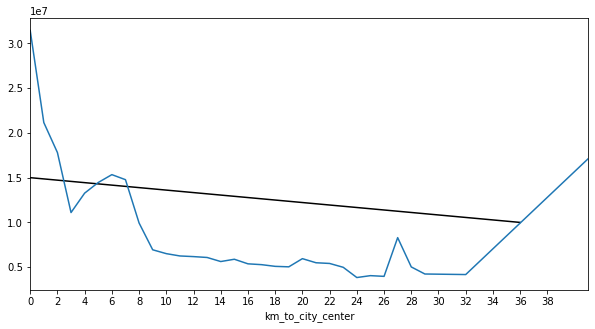

In [58]:
plt.plot([0, 36], [1.5*10**7, 1*10**7], 'k-')
new_df.groupby(['km_to_city_center'])['last_price'].agg('mean').plot(figsize=(10,5), xticks=np.arange(0,40,2))

So from this graph I can see that around 8 km we have a drop down and from 32 increase again. Therefore I'll filter the data and save those with value <= 8km and >= 36km

In [59]:
new_df = new_df[(new_df['km_to_city_center'] <= 8) | (new_df['km_to_city_center'] >=36)]

In [60]:
new_df.shape

(4141, 30)

In [61]:
to_check = new_df[['total_area', 'last_price', 'rooms', 'ceiling_height','price_per_sq_meter','floor_status']]

In [62]:
#clean the df from the parameters from before:
to_check = to_check[(to_check['rooms'] <= to_check['rooms'].quantile(0.98))
                    & (to_check['ceiling_height'] <= to_check['ceiling_height'].quantile(0.98))
                    & (to_check['last_price'] <= to_check['last_price'].quantile(0.98))
                    & (to_check['total_area'] <= 200)]

In [63]:
import matplotlib

In [64]:
matplotlib.__version__

'3.2.0'

In [65]:
to_check.shape

(3857, 6)

I did not lose too much rows so its ok.

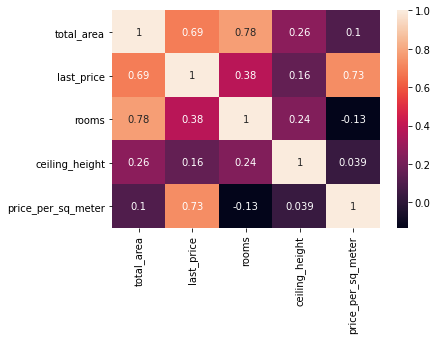

In [66]:
sns.heatmap(to_check.corr(), annot=True)

### Conclusion

After finding the most beneficial apartments in the St. Petersburg Area I found out that:
<ul>
    <li> Correlation between rooms and total area is high (0.78) </li>
    <li> Correlation between last price and total area is medium (0.69)</li>
    <li> Between last price and rooms we have also medium correlation. (0.38) </li>
    <li> All other columns we have small correlation. </li>
    
</ul>

#### Task
•Select a segment of apartments in the downtown, then analyze this area and examine the following parameters: square area, price, number of rooms, ceiling height. Also identify the factors that affect an apartment’s price (number of rooms, floor, distance to the downtown area, and ad publication date). Draw your conclusions. Are they different from the overall deductions about the entire city?

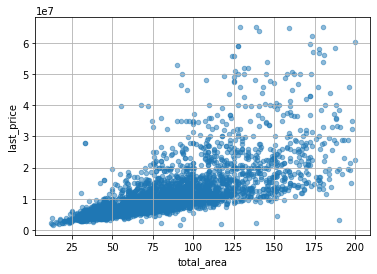

In [67]:
to_check.plot(y='last_price',x ='total_area', kind='scatter', alpha =0.5,grid=True)

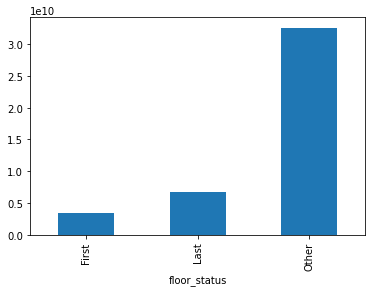

In [68]:
to_check.groupby(['floor_status'])['last_price'].agg('sum').plot(kind='bar')

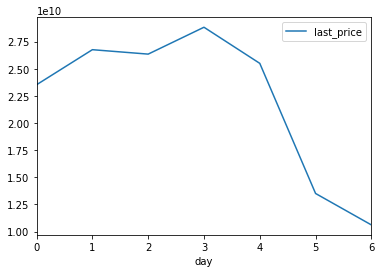

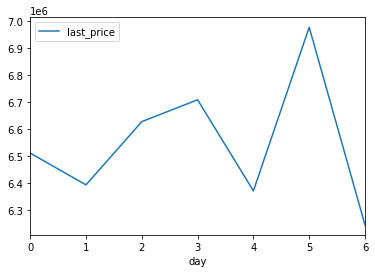

In [69]:
df.pivot_table(index='day',values='last_price',aggfunc='sum').plot()
df.pivot_table(index='day',values='last_price',aggfunc='mean').plot()

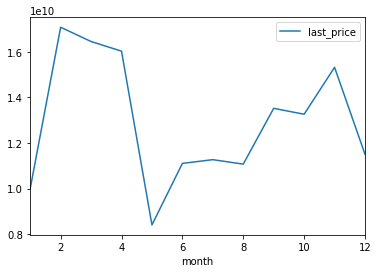

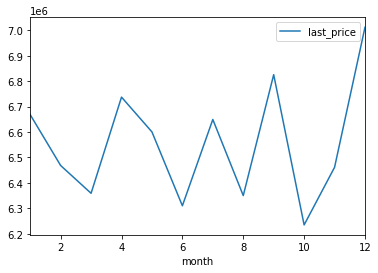

In [70]:
df.pivot_table(index='month',values='last_price',aggfunc='sum').plot()
df.pivot_table(index='month',values='last_price',aggfunc='mean').plot()

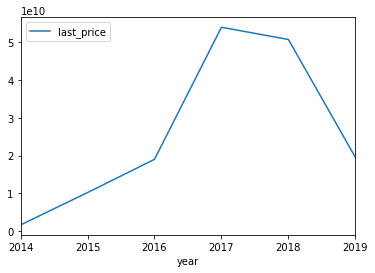

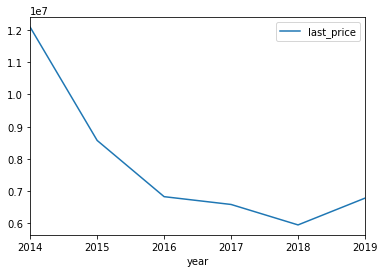

In [71]:
df.pivot_table(index='year',values='last_price',aggfunc='sum').plot()
df.pivot_table(index='year',values='last_price',aggfunc='mean').plot()

### Step 5. Overall conclusion

This data had a lot of missins data.

I had to do bunch of pre-process to make the data readable and useable. After cleaning the data I could tell that the majority of apartments are from St. Petersburg.

Based on the data analysis we can see that days exposition is skewed
to the left which means that most of the apartments were sold before
the mean of the data. 

After cleaning the data and checking the St. Petersburg homes for the
nearst downtown we saw that most of the are located up to 8km or above 36.

Once I took only the "good" data I saw that:

<ol>
 <li> We had some columns with high correlation and most of them with
	weak correlation</li>
<li> We saw increase in last price as function of increase in total area</li>
<li> Most of "other" floor status had the selling which means
	people intend to not buy the first or last floor</li>
<li> On day 5 and 6 (Saturday and Sunday) we see a 
decrease on sum in sales which can happen because maybe they do not
work at these days and its easier for them to buy during the week </li>
<li> About month we see a decrease on May and the mean does not
really tell us something</li>
<li> In years we can see increase of sales around 2016-2018</li>
</ol>